# KIC 8462852 (Boyajian's Star) spectroscopic follow up
## [Brett Morris](mailto:bmmorris@uw.edu) and Jim Davenport
#### Apache Point Observatory ARC 3.5 m telescope, ARCES echelle spectrograph

This notebook contains code for retrieving my [APO ARC 3.5 m/ARCES](http://www.apo.nmsu.edu/arc35m/Instruments/ARCES/) (R~31,500) spectrum of Boyajian's Star (KIC 8462852) at 2017-05-20 10:34 UTC. It downloads the wavelength-calibrated spectra from my webpage and caches them locally, then normalizes the continuum using the spectroscopic standard [BD +28 4211](https://www.eso.org/sci/observing/tools/standards/spectra/bd28d4211.html), and shifts the wavelengths to the star's rest frame. The telluric standard star [HR 7916](http://simbad.harvard.edu/simbad/sim-basic?Ident=HR7916&submit=SIMBAD+search) (spectral type F2Vn) is also included. 

<img src="http://staff.washington.edu/bmmorris/images/light_curve.png" alt="Light curve" style="width: 500px;"/>



In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.time import Time
from toolkit import EchelleSpectrum

Download and cache spectra:

In [32]:
kic8462852_1_url = 'http://staff.washington.edu/bmmorris/docs/KIC8462852.0001.wfrmcpc.fits'
kic8462852_2_url = 'http://staff.washington.edu/bmmorris/docs/KIC8462852.0003.wfrmcpc.fits'
kic8462852_3_url = 'http://staff.washington.edu/bmmorris/docs/KIC8462852.0065.wfrmcpc.fits'

spectroscopic_standard_url = 'http://staff.washington.edu/bmmorris/docs/BD28_4211.0034.wfrmcpc.fits'
telluric_standard_url = 'http://staff.washington.edu/bmmorris/docs/HR7916.0002.wfrmcpc.fits'

target_spectrum_1 = EchelleSpectrum.from_fits_url(kic8462852_1_url)
target_spectrum_2 = EchelleSpectrum.from_fits_url(kic8462852_2_url)
target_spectrum_3 = EchelleSpectrum.from_fits_url(kic8462852_3_url)

spectroscopic_standard = EchelleSpectrum.from_fits_url(spectroscopic_standard_url)
telluric_standard = EchelleSpectrum.from_fits_url(telluric_standard_url)

Fit a polynomial of order ``polynomial_order`` to each spectral order of the spectrum of ``spectroscopic_standard``, then normalize each spectral order by that polynomial to remove the blaze function.

In [33]:
only_orders = np.arange(len(target_spectrum_1.spectrum_list))
target_spectrum_1.continuum_normalize(spectroscopic_standard,
                                    polynomial_order=10,
                                    only_orders=only_orders,
                                    plot_masking=False)

only_orders = np.arange(len(target_spectrum_2.spectrum_list))
target_spectrum_2.continuum_normalize(spectroscopic_standard,
                                    polynomial_order=10,
                                    only_orders=only_orders,
                                    plot_masking=False)

only_orders = np.arange(len(target_spectrum_3.spectrum_list))
target_spectrum_3.continuum_normalize(spectroscopic_standard,
                                    polynomial_order=10,
                                    only_orders=only_orders,
                                    plot_masking=False)

telluric_standard.continuum_normalize(spectroscopic_standard,
                                      polynomial_order=10,
                                      only_orders=only_orders,
                                      plot_masking=False)

Calculate the wavelength offset necessary to shift the spectra into the star's rest frame, then shift the wavelengths accordingly.

In [34]:
rv_shifts = u.Quantity([target_spectrum_1.rv_wavelength_shift(order)
                        for order in only_orders])
median_rv_shift = np.median(rv_shifts)
target_spectrum_1.offset_wavelength_solution(median_rv_shift)

rv_shifts = u.Quantity([target_spectrum_2.rv_wavelength_shift(order)
                        for order in only_orders])
median_rv_shift = np.median(rv_shifts)
target_spectrum_2.offset_wavelength_solution(median_rv_shift)

rv_shifts = u.Quantity([target_spectrum_3.rv_wavelength_shift(order)
                        for order in only_orders])
median_rv_shift = np.median(rv_shifts)
target_spectrum_3.offset_wavelength_solution(median_rv_shift)

rv_shifts = u.Quantity([telluric_standard.rv_wavelength_shift(order)
                        for order in only_orders])
median_rv_shift = np.median(rv_shifts)
telluric_standard.offset_wavelength_solution(median_rv_shift)

Download a PHOENIX model atmosphere ([Husser 2013](https://arxiv.org/abs/1303.5632)) for comparison with Boyajian's star, with $T_{eff}=6800$ K and $\log g = 4.0$.

In [35]:
from toolkit import get_phoenix_model_spectrum

phoenix_6800_40 = get_phoenix_model_spectrum(6800, 4.0)

Define some convenience functions for plotting spectral features:

In [36]:
def get_nearest_order(feature_wavelength):
    return np.argmin([np.abs(feature_wavelength - target_spectrum_1.get_order(i).wavelength.mean().value) 
                     for i in range(len(target_spectrum_1.spectrum_list))])

def plot_spectral_feature(spectrum, center_wavelength, width_angstroms, 
                          phoenix_model=phoenix_6800_40, plot_model=True,
                          label=None, title=None, ax=None, legend=True,
                          spectrum_kwargs=None, model_kwargs=None):
    """
    Plot the spectrum, centered on wavelength ``center_wavelength``, with width
    ``width_angstroms``.
    """

    if ax is None:
        ax = plt.gca()
        
    if title is None:
        title = 'APO/ARCES (Brett Morris)'
        
    if spectrum_kwargs is None:
        spectrum_kwargs = dict(lw=1, color='k')
        
    if model_kwargs is None:
        model_kwargs = dict(label='PHOENIX model', color='r', alpha=0.5)

    feature_order = spectrum.get_order(get_nearest_order(center_wavelength))
    normed_flux = feature_order.masked_flux / np.median(feature_order.masked_flux)
    ax.plot(feature_order.masked_wavelength,  normed_flux,
            label=spectrum.name, **spectrum_kwargs)
    
    model_already_plotted = any([line.get_label().startswith('PHOENIX')
                                 for line in ax.get_lines()])
    
    if plot_model and not model_already_plotted:
        model_wavelength_range = ((phoenix_6800_40.wavelength.value  < center_wavelength + width_angstroms/2) & 
                                  (phoenix_6800_40.wavelength.value > center_wavelength - width_angstroms/2))
        normed_model_flux = phoenix_6800_40.flux / np.median(phoenix_6800_40.flux)
        normed_model_flux *= (np.median(normed_flux) / 
                              normed_model_flux[model_wavelength_range].max())
        ax.plot(phoenix_6800_40.wavelength, normed_model_flux,
                **model_kwargs)

    ax.set_title(title)
    ax.set_xlabel('Wavelength [Angstrom]')
    ax.set_ylabel('Flux')
    ax.set_xlim([center_wavelength - width_angstroms/2, 
                 center_wavelength + width_angstroms/2])
    ax.set_ylim([0, 1.1*normed_flux.max()])
    if legend:
        ax.legend(fontsize=10, bbox_to_anchor=(0, 1, 1.4, 0))
    ax.get_xaxis().get_major_formatter().set_useOffset(False)

    return ax

In [37]:
obs_time = Time(target_spectrum_1.header['DATE-OBS'], format='isot')
print("Date of observation (UTC): ", obs_time.datetime)
target_spectrum_1.name += " " + str(obs_time.datetime.date())

obs_time = Time(target_spectrum_2.header['DATE-OBS'], format='isot')
print("Date of observation (UTC): ", obs_time.datetime)
target_spectrum_2.name += " " + str(obs_time.datetime.date())

obs_time = Time(target_spectrum_3.header['DATE-OBS'], format='isot')
print("Date of observation (UTC): ", obs_time.datetime)
target_spectrum_3.name += " " + str(obs_time.datetime.date())

Date of observation (UTC):  2017-05-20 10:34:34.285000
Date of observation (UTC):  2017-06-12 08:18:44.641000
Date of observation (UTC):  2017-06-15 05:01:32.040000


Plot the NaD absorption features.

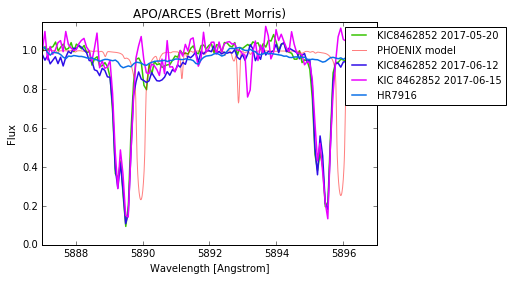

In [43]:
plot_spectral_feature(target_spectrum_1, 5892, 10, spectrum_kwargs=dict(lw=1.5, color='#36C400'))

plot_spectral_feature(target_spectrum_2, 5892, 10, spectrum_kwargs=dict(lw=1.5, color='#2D0CE8'))

plot_spectral_feature(target_spectrum_3, 5892, 10, spectrum_kwargs=dict(lw=1.5, color='#EA00FF'))

plot_spectral_feature(telluric_standard, 5892, 10, spectrum_kwargs=dict(lw=1.5, color='#0B70E8'))

Plot the spectrum at H$\alpha$ and H$\beta$.

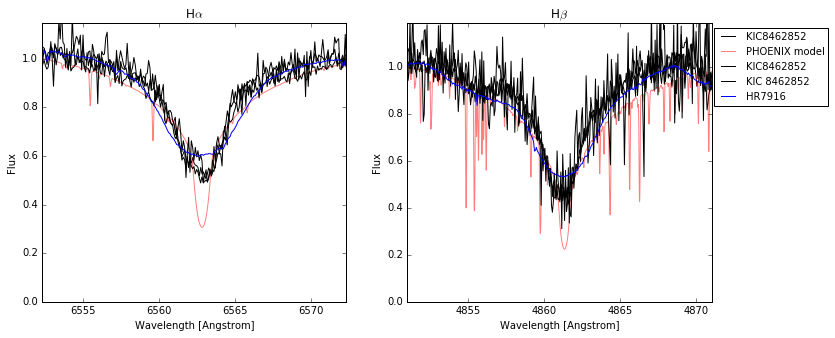

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# H-alpha
plot_spectral_feature(target_spectrum_1, 6562.3, 20, ax=ax[0], legend=False)
plot_spectral_feature(target_spectrum_2, 6562.3, 20, ax=ax[0], legend=False)
plot_spectral_feature(target_spectrum_3, 6562.3, 20, ax=ax[0], legend=False)

plot_spectral_feature(telluric_standard, 6562.3, 20, ax=ax[0],
                      spectrum_kwargs=dict(lw=1, color='b'), legend=False,
                      title=r'H$\alpha$')

# H-beta
plot_spectral_feature(target_spectrum_1, 4861, 20, ax=ax[1], legend=False)
plot_spectral_feature(target_spectrum_2, 4861, 20, ax=ax[1], legend=False)
plot_spectral_feature(target_spectrum_3, 4861, 20, ax=ax[1], legend=False)

plot_spectral_feature(telluric_standard, 4861, 20, ax=ax[1],
                      spectrum_kwargs=dict(lw=1, color='b'), legend=True,
                      title=r'H$\beta$')

Fit the NaD absorption features to measure the approximate equivalent width, for comparison with [these results Jason Curtis](http://sites.psu.edu/astrowright/2016/08/31/what-could-be-going-on-with-boyajians-star-part-iii-periodic-dips-and-interstellar-sodium/) on Jason Wright's blog: equivalent width = 420 mÅ.

Optimization terminated successfully.
         Current function value: 1.109061
         Iterations: 4
         Function evaluations: 578


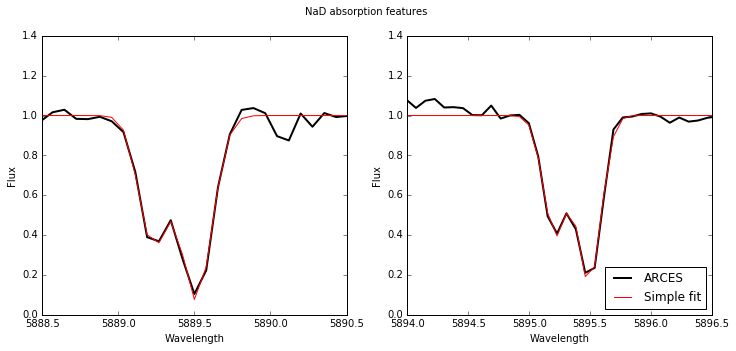

In [20]:
from scipy.optimize import fmin_powell

def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-0.5 * (mean - x)**2 / sigma**2)

def four_gaussians(wavelength, amp1, amp2, amp3, amp4, 
                          mean1, mean2, mean3, mean4, 
                          sig1, sig2, sig3, sig4):
    return (1 + gaussian(wavelength, amp1, mean1, sig1) + 
            gaussian(wavelength, amp2, mean2, sig2) + 
            gaussian(wavelength, amp3, mean3, sig3) + 
            gaussian(wavelength, amp4, mean4, sig4)) 

def chi2(params, wavelength, flux):
    return np.sum((four_gaussians(wavelength, *params) - flux)**2)

# Get the spectral order with the NaD feature
na_feature_wavelength = 5892
na_order_target = target_spectrum_1.get_order(get_nearest_order(na_feature_wavelength))
na_order_telluric = telluric_standard.get_order(get_nearest_order(na_feature_wavelength))

# Normalize the spectrum by a low order polynomial
lam = na_order_target.masked_wavelength.value
flux = na_order_target.masked_flux.value / na_order_telluric.masked_flux.value
continuum_params = np.polyfit(lam-lam.mean(), flux, 2)
flux /= np.polyval(continuum_params, lam-lam.mean()) 

# Initial gaussian amplitudes, means, and standard deviations
init_params = [-0.8, -0.5, -0.5, -0.4, 
               5889.5, 5889.2, 5895.5, 5895.2, 
               0.1, 0.1, 0.1, 0.1]

# Minimize the chi2
best_params = fmin_powell(chi2, init_params, args=(lam, flux))

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(lam, flux, 'k-', lw=2, label='ARCES')
ax[0].set_xlim([5888.5, 5890.5])
ax[0].plot(lam, four_gaussians(lam,  *best_params), 'r', label='Simple fit')
ax[0].set_xlabel('Wavelength')
ax[0].set_ylabel('Flux')

ax[1].plot(lam, flux, 'k-', lw=2, label='ARCES')
ax[1].set_xlim([5894, 5896.5])
ax[1].plot(lam, four_gaussians(lam,  *best_params), 'r', label='Simple fit')
ax[1].set_xlabel('Wavelength')
ax[1].set_ylabel('Flux')
ax[1].legend(loc='lower right')

fig.suptitle('NaD absorption features')

for axis in ax:
    axis.get_xaxis().get_major_formatter().set_useOffset(False)

In [21]:
from scipy.integrate import quad
a = 5888.5
b = 5890
c = 5894.5
d = 5896.5
integral1, err = quad(lambda x: four_gaussians(x, *best_params), a, b)
integral2, err = quad(lambda x: four_gaussians(x, *best_params), c, d)

equivalent_width1 = ((b-a) - integral1)
equivalent_width2 = ((d-c) - integral2)

print("NaD equivalent width (at 5889.5 A):", equivalent_width1, "Angstrom")
print("NaD equivalent width (at 5895.5 A):", equivalent_width2, "Angstrom")

NaD equivalent width (at 5889.5 A): 0.3887883297520771 Angstrom
NaD equivalent width (at 5895.5 A): 0.3464204748924282 Angstrom
